# Project McNulty

*Project 3 of Metis Data Science Bootcamp.* Problem statement below:  

Use supervised learning and classification methods to model a discrete response variable in a data set.

I am using a data set detailing various elements of patients' medical records in order to predict whether or not they will be diagnosed with coronary artery disease. My goal is to find a model that accurately preducts heart disease diagnosis for both men and women so that I can compare the weight of features in both models.  

The features are:  
1. ECG Reading during Exercise (slope)  
2. ECG Reading during Rest (restecg)  
3. Chest Pain Type (value 1-4)  
4. Exercise induced angina (exang--boolean)  
5. Hypertension (htn--boolean)
6. Age  
7. Cholesterol (chol)  
8. Resting Heart Rate (thalrest)  
9. Peak Heart Rate during exercise (thalach)  
10. Resting BP (trestbp--Sys. + Dias.)
11. Peak BP (tpeakbp--Sys. + Dias.)  

Response variable (num) = 1 for positive diagnosis, 0 for negative diagnosis

In [37]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from collections import defaultdict
from pprint import pprint
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import normalize,scale,MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import seaborn

### Pulling in data tables:

In [13]:
fem=pd.read_csv('fem5.csv')
fem.head()

,num,slope,htn,restecg,exang,age,chol,thalach,thalrest,trestbp,tpeakbp,1,2,3,4
0,0,1,1,2,0,41,204,172,71,216,234,0,1,0,0
1,1,3,0,2,0,62,268,160,83,240,264,0,0,0,1
2,0,1,1,0,1,57,354,163,84,200,245,0,0,0,1
3,0,2,0,2,0,56,294,153,85,240,322,0,1,0,0
4,0,1,1,0,0,48,275,139,62,210,240,0,0,1,0


In [14]:
male=pd.read_csv('male5.csv')
male.head()

,num,slope,htn,restecg,exang,age,chol,thalach,thalrest,trestbp,tpeakbp,1,2,3,4
0,0,3,1,2,0,63,233,150,60,230,280,1,0,0,0
1,1,2,1,2,1,67,286,108,64,250,250,0,0,0,1
2,1,2,1,2,1,67,229,129,78,200,220,0,0,0,1
3,0,3,0,0,0,37,250,187,84,208,263,0,0,1,0
4,0,1,1,0,0,56,236,178,73,195,235,0,1,0,0


### Train/test splits: 

In [15]:
train_f, test_f = train_test_split(fem, test_size = 0.30, random_state=4444)
x_train_f=train_f.iloc[:,1:]
y_train_f=train_f.iloc[:,0]
x_test_f=test_f.iloc[:,1:]
y_test_f=test_f.iloc[:,0]
x_f=fem.iloc[:,1:]
y_f=fem.iloc[:,0]

In [16]:
train_m, test_m = train_test_split(male, test_size = 0.30, random_state=4444)
x_train_m=train_m.iloc[:,1:]
y_train_m=train_m.iloc[:,0]
x_test_m=test_m.iloc[:,1:]
y_test_m=test_m.iloc[:,0]
x_m=male.iloc[:,1:]
y_m=male.iloc[:,0]

### Logistic Regression Grid Search:

In [17]:
def GS_LR(x_train,y_train,x_test,y_test,model,s):
    parameters={'C': [0.001, 0.01, 0.05, 0.25, 0.1, 1, 10, 100, 1000],'penalty':['l1','l2'] }
    scores=['accuracy','precision','recall','f1']
    mod_dict=defaultdict(list)
    
    for score in scores:
        gs = GridSearchCV(model,parameters,cv=5,scoring=score)
        gs.fit(x_train,y_train)
        mod_dict[score]=gs.best_estimator_
    best_model=mod_dict[s]
    best_model.fit(x_train,y_train)
    
    return best_model

In [18]:
LR_m=GS_LR(x_train_m,y_train_m,x_test_m,y_test_m,LogisticRegression(),'recall')

In [19]:
LR_f=GS_LR(x_train_f,y_train_f,x_test_f,y_test_f,LogisticRegression(),'recall')

### Linear SVC Grid Search:

In [20]:
SVC_m=GS_LR(x_train_m,y_train_m,x_test_m,y_test_m,LinearSVC(dual=False),'recall')

In [21]:
SVC_f=GS_LR(x_train_f,y_train_f,x_test_f,y_test_f,LinearSVC(dual=False),'recall')

### K Nearest Neighbors (search for optimal k):

In [22]:
def find_k(x_train,y_train,x_test,y_test):
    KNNscores=[]
    for n in range(1,50):
        neigh = KNeighborsClassifier(n_neighbors=n)
        neigh.fit(x_train,y_train)
        KNNscores.append(recall_score(y_test,neigh.predict(x_test)))
    return KNNscores.index(max(KNNscores))+1

In [23]:
KNN_m=find_k(x_train_m,y_train_m,x_test_m,y_test_m)
KNN_m

31

In [24]:
KNN_f=find_k(x_train_f,y_train_f,x_test_f,y_test_f)
KNN_f

1

### Random Forest Grid Search:

In [25]:
def GS_RF(x_train,y_train,x_test,y_test,model,s):
    parameters={'max_depth':[1,5,10],'max_features':[1,5,10],'n_estimators':(250,500,1000)}
    scores=['accuracy','precision','recall','f1']
    mod_dict=defaultdict(list)
    for score in scores:
        gs = GridSearchCV(model,parameters,cv=5,scoring=score)
        gs.fit(x_train,y_train)
        mod_dict[score]=gs.best_estimator_
    best_model=mod_dict[s]
    best_model.fit(x_train,y_train)
    
    return best_model

In [26]:
RF_m=GS_RF(x_train_m,y_train_m,x_test_m,y_test_m,RandomForestClassifier(random_state=4444),'recall')

In [27]:
RF_f=GS_RF(x_train_f,y_train_f,x_test_f,y_test_f,RandomForestClassifier(random_state=4444),'recall')

### Calculate scoring for each model using cross-validation:

In [28]:
models_m=[LR_m,RF_m,GaussianNB(),SVC_m,KNeighborsClassifier(n_neighbors=31)]
models_f=[LR_f,RF_f,GaussianNB(),SVC_f,KNeighborsClassifier(n_neighbors=1)]

In [29]:
def cv_scoremodel(models, x_train, y_train, x, y):
    scores=['accuracy','recall']
    score_dict=defaultdict(list)
    #score_dict={}
    for mod in models:
        mod.fit(x_train,y_train)
        for i in range(len(scores)):
            score_dict[str(mod)[:str(mod).index('(')]].append(np.mean(cross_val_score(mod, x, y, cv=10, scoring='{}'.format(scores[i]))))
    comb=pd.DataFrame(score_dict.values(),index=score_dict.keys(),columns=scores)
    return comb
    

### Finding cross-validation scores for all models: 

In [30]:
CVS_m=cv_scoremodel(models_m, x_train_m, y_train_m, x_m, y_m)

In [31]:
CVS_m

,accuracy,recall
LinearSVC,0.734894,0.913420
LogisticRegression,0.663575,1.000000
KNeighborsClassifier,0.722388,0.904329
GaussianNB,0.774951,0.802597
RandomForestClassifier,0.663575,1.000000


In [32]:
CVS_f=cv_scoremodel(models_f, x_train_f, y_train_f, x_f, y_f)


In [33]:
CVS_f

,accuracy,recall
LinearSVC,0.784499,0.625000
LogisticRegression,0.775408,0.591667
KNeighborsClassifier,0.581235,0.333333
GaussianNB,0.702098,0.808333
RandomForestClassifier,0.775932,0.500000


In [34]:
CVS_acc=pd.DataFrame({"Male":CVS_m.accuracy,"Female":CVS_f.accuracy})
CVS_rec=pd.DataFrame({"Male":CVS_m.recall,"Female":CVS_f.recall})

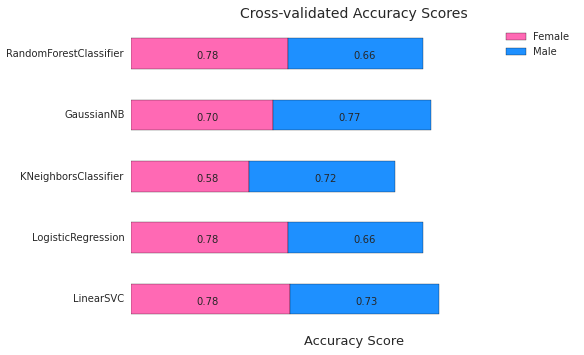

In [38]:
my_colors=['#FF69B4','#1E90FF']
p=CVS_acc.plot(kind='barh', stacked=True,xlim=[0,2.2],xticks=np.arange(0.0,2.0,0.2),color=my_colors)
p.set_axis_bgcolor('white')
p.legend(loc='best')
p.set_xlabel('Accuracy Score',fontsize=13)
p.set_title('Cross-validated Accuracy Scores',fontsize=14)
plt.setp( p.get_xticklabels(), visible=False)

for a in p.patches:
    p.annotate("%.2f" % a.get_width(), (a.get_x() + 0.3, a.get_y()), xytext=(5, 10), textcoords='offset points')


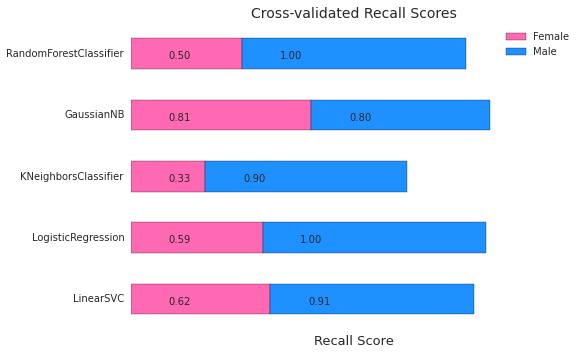

In [39]:
my_colors=['#FF69B4','#1E90FF']
p2=CVS_rec.plot(kind='barh', stacked=True,xlim=[0,2.0],xticks=np.arange(0.0,2.0,0.2),color=my_colors)
p2.set_axis_bgcolor('white')
p2.legend(loc='best')
p2.set_xlabel('Recall Score',fontsize=13)
p2.set_title('Cross-validated Recall Scores',fontsize=14)
plt.setp( p2.get_xticklabels(), visible=False)

for a in p2.patches:
    p2.annotate("%.2f" % a.get_width(), (a.get_x() + 0.15, a.get_y()), xytext=(5, 10), textcoords='offset points')


### Feature analysis: 

In [665]:
train_new,test_new=train_test_split(fem[fem.num==0],test_size=0.3,random_state=4444)

In [828]:
def histplotsm(df):
    labels=['Resting Heart Rate','Age','Resting Blood Pressure (Sys. + Dias.)']
    cols=['thalach','age','trestbp']
    for col in cols:
        fig=plt.figure(figsize=(5,5))
        ax=plt.subplot(111)
        df[df.num==1][col].hist(label='Positive Diagnosis',alpha=0.5,bins=60,color='r')
        df[df.num==0][col].hist(label='Negative Diagnosis',alpha=0.5,bins=60,color='g')
        plt.legend(loc='upper left',prop={'size':10})
        ax.grid(b=False)
        ax.set_axis_bgcolor('white')
        plt.xlabel(labels[cols.index(col)],fontsize=20)
        plt.ylabel('Count')

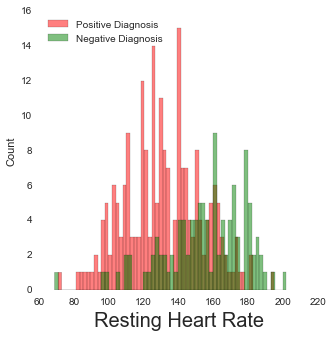

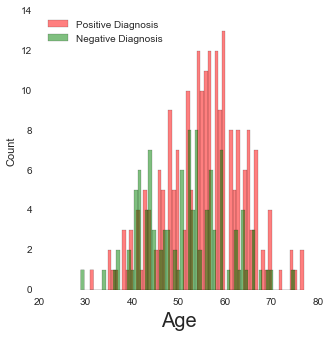

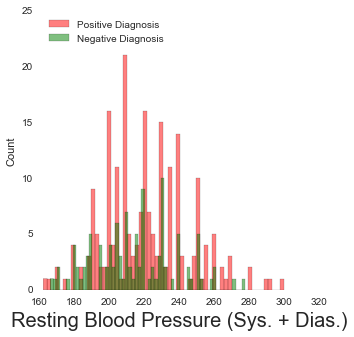

In [829]:
histplotsm(male)

In [842]:
fem=fem[fem.chol!=0]

In [843]:
def histplotsf(df,train):
    cols=['trestbp','chol','age','thalrest','tpeakbp','thalach']
    labels=['Resting Blood Pressure (Sys. + Dias.)','Cholesterol','Age','Resting Heart Rate','Peak Blood Pressure (Sys. + Dias.)','Peak Heart Rate']
    for col in cols:
        plt.figure(figsize=(5,5))
        ax=plt.subplot(111)
        df[df.num==1][col].hist(label='Positive Diagnosis',alpha=0.5,bins=50,color='r')
        train[col].hist(label='Negative Diagnosis',alpha=0.5,bins=50,color='g')
        plt.legend(loc='best')
        plt.legend(loc='upper left',prop={'size':10})
        ax.grid(b=False)
        ax.set_axis_bgcolor('white')
        plt.xlabel(labels[cols.index(col)],fontsize=20)
        plt.ylabel('Count')
        ax.grid(b=False)
        ax.set_axis_bgcolor('white')

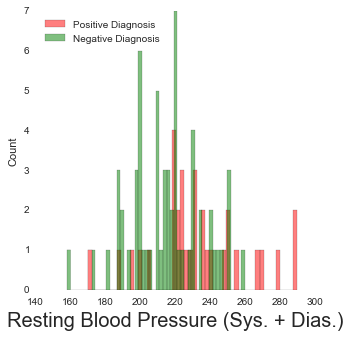

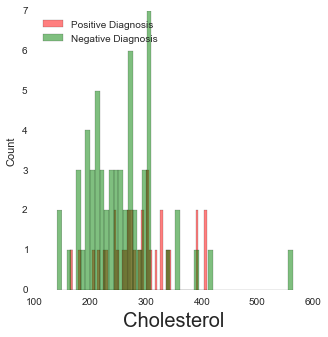

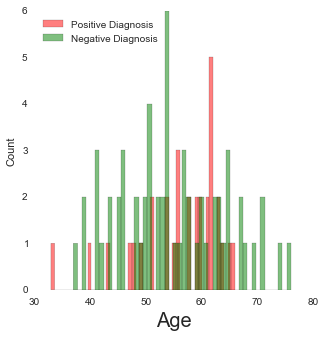

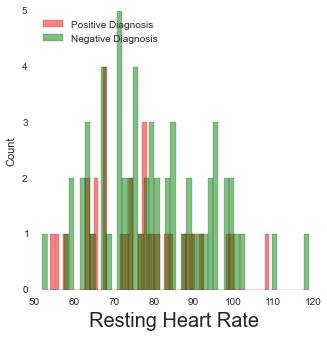

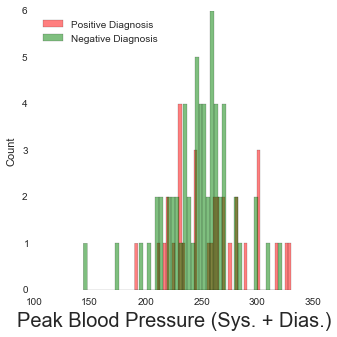

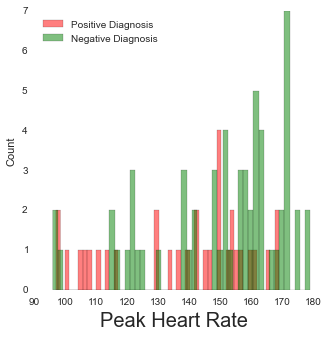

In [844]:
histplotsf(fem,train_new)

### Confusion Matrix: 

In [792]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model,x_train,y_train,x_test,y_test,gender,cmap=plt.cm.Blues):
    y_pred = model.fit(x_train, y_train).predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm_normalized)
    fig=plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.title('Normalized Confusion Matrix: {}'.format(gender),fontsize=16)
    plt.colorbar()
    plt.xticks([0,1],['Negative diagnosis','Positive Diagnosis'],fontsize=12)
    plt.yticks([0,1],['Negative diagnosis','Positive Diagnosis'],fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label',fontsize=14,weight='bold',rotation=90)
    plt.xlabel('Predicted label',fontsize=14,weight='bold')
    ax.grid(b=False)
    ax.xaxis.labelpad = 20
    labels=['True Negative','False Positive','False Negative','True Positive']
    for i, cas in enumerate(cm_normalized):
        for j, c in enumerate(cas):
            plt.text(j-.15, i+.05, round(c,2), fontsize=20,color='black',weight='bold')

[[ 0.77777778  0.22222222]
 [ 0.20967742  0.79032258]]


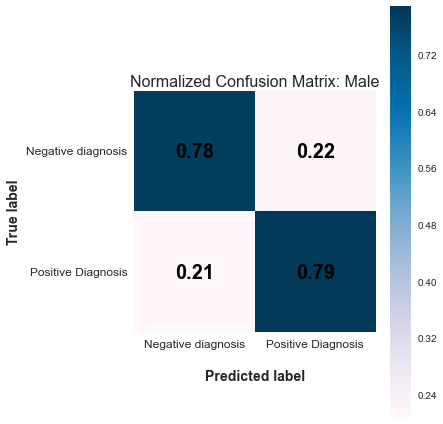

In [793]:
plot_confusion_matrix(GaussianNB(),x_train_m,y_train_m,x_test_m,y_test_m,'Male',cmap=plt.cm.PuBu)

[[ 0.67857143  0.32142857]
 [ 0.125       0.875     ]]


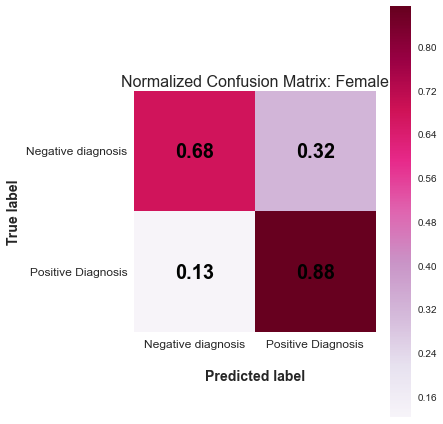

In [845]:
plot_confusion_matrix(GaussianNB(),x_train_f,y_train_f,x_test_f,y_test_f,'Female',cmap=plt.cm.PuRd)